<img src="https://www.clickz.com/wp-content/uploads/2017/10/online-to-offline_900.jpg" alt="Drawing" style="width: 100px;"/>

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
The aim of this analysis is to segement the Customers based on RFM so that the company can target its customers efficiently.

<a id="1"></a> <br>
## Step 1 : Understanding Data🤔

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Reading the data on which analysis needs to be done

# retail = pd.read_csv('/Users/mohitgupta_omg/Desktop/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# shape of df

retail.shape

(541909, 8)

In [4]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<a id="2"></a> <br>
## Step 2 : Data Cleansing🧹

In [6]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [8]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [9]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
retail['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [11]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [13]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [14]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [16]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [17]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [18]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

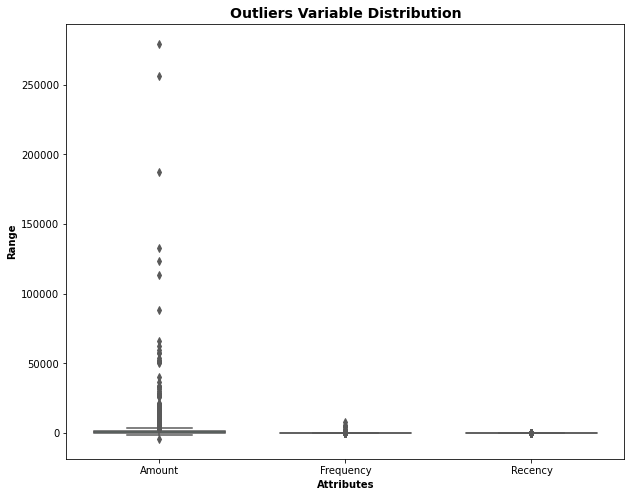

In [19]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')



In [20]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

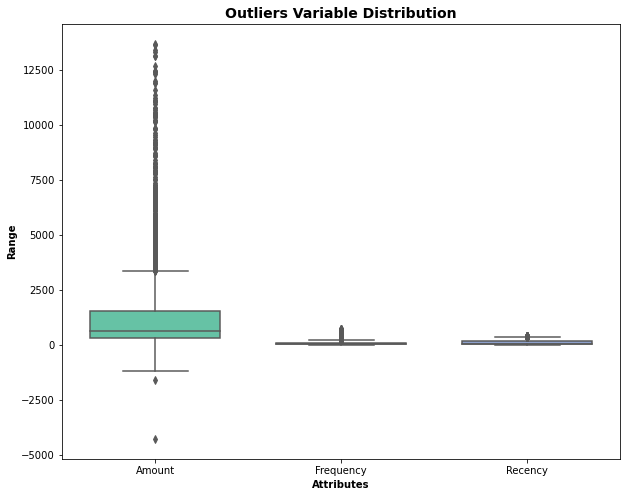

In [21]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')


### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [22]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [23]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

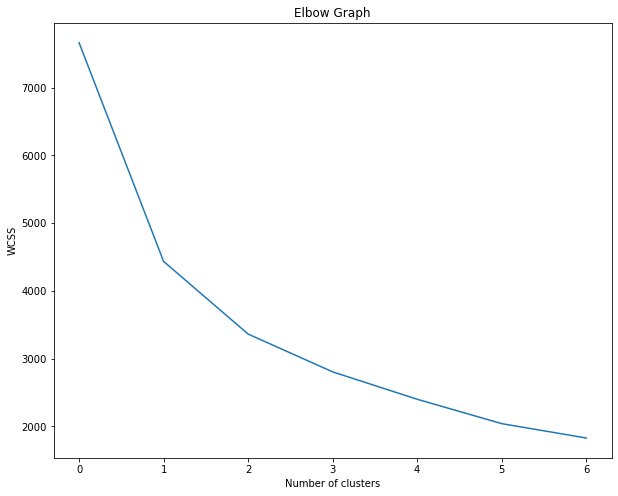

In [24]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.title('Elbow Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [26]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0], dtype=int32)

In [27]:
kmeans.cluster_centers_

array([[-0.18199972, -0.17959307, -0.47579335],
       [-0.50237552, -0.51846606,  1.54212771],
       [ 2.06497258,  2.08622573, -0.70091104]])

In [28]:
cluster_data= rfm_df.copy()
cluster_data['cluster_pred'] = kmeans.fit_predict(rfm_df_scaled)

In [29]:
cluster_data.head()

,Amount,Frequency,Recency,cluster_pred
0,0.00,2,325,2
1,4310.00,182,1,1
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,2


In [30]:
cluster_data.loc[cluster_data['cluster_pred']==0]

,Amount,Frequency,Recency,cluster_pred
2,1797.24,31,74,0
3,1757.55,73,18,0
5,1545.41,95,35,0
9,2811.43,59,22,0
11,1168.06,19,1,0
...,...,...,...,...
4364,323.36,16,20,0
4365,97.63,9,57,0
4366,173.90,9,73,0
4369,176.60,13,7,0


# Agglomarative Clustering

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [32]:
link = linkage(rfm_df_scaled, method = 'complete')

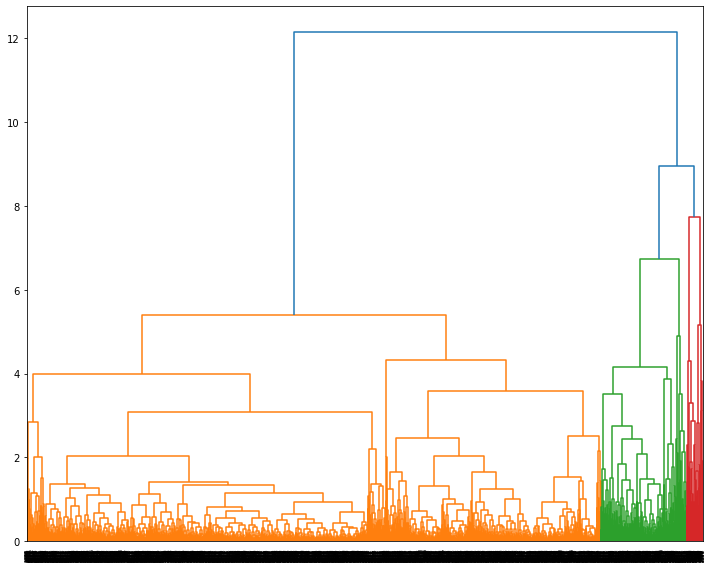

In [33]:
fig, ax = plt.subplots(figsize = (10,8))
ax = dendrogram(link)
plt.tight_layout()
plt.show()

In [34]:
from sklearn.cluster import AgglomerativeClustering

In [35]:
ag_cluster = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean')

In [36]:
ag_cluster.fit(rfm_df_scaled)

AgglomerativeClustering()

In [37]:
cluster_data= rfm_df.copy()
cluster_data['cluster_pred'] = ag_cluster.fit_predict(rfm_df_scaled)

In [38]:
cluster_data.head()

,Amount,Frequency,Recency,cluster_pred
0,0.00,2,325,0
1,4310.00,182,1,1
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,0


### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [39]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48185311563746536
For n_clusters=5, the silhouette score is 0.46447926172371196
For n_clusters=6, the silhouette score is 0.4176921719944174
For n_clusters=7, the silhouette score is 0.41512888153967176
For n_clusters=8, the silhouette score is 0.4077185971841525


In [40]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [41]:
 kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [42]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


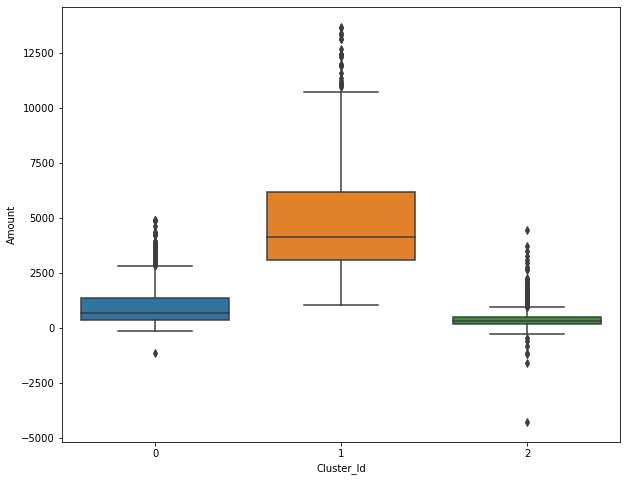

In [43]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

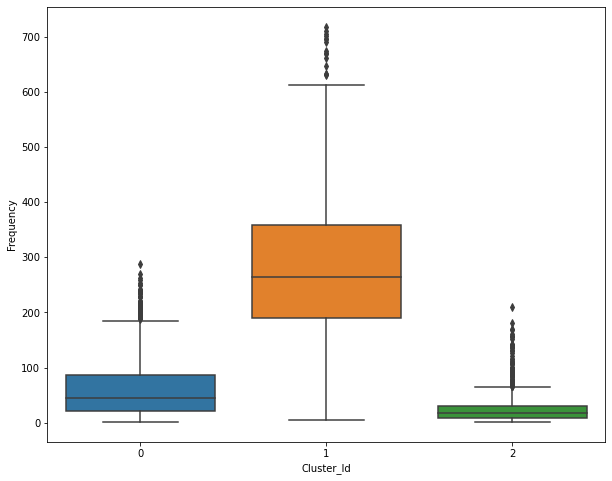

In [44]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

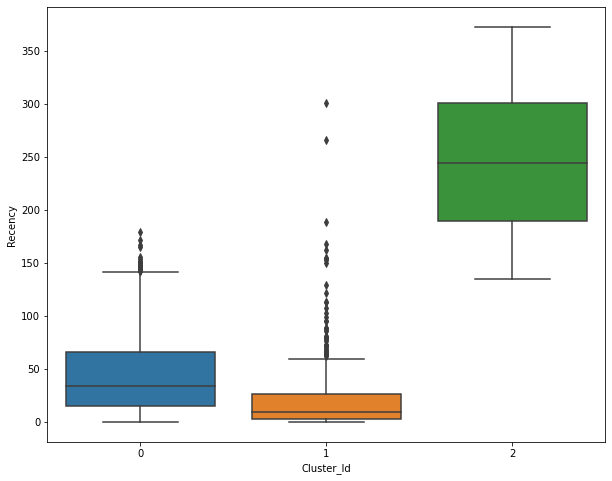

In [45]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, 
- Divisive 
- Agglomerative.

**Single Linkage:<br>**

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
![](https://www.saedsayad.com/images/Clustering_single.png)

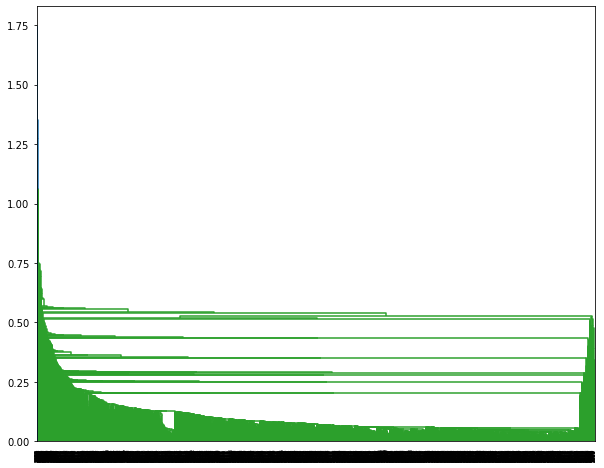

In [46]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage<br>**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points. 
![](https://www.saedsayad.com/images/Clustering_complete.png)

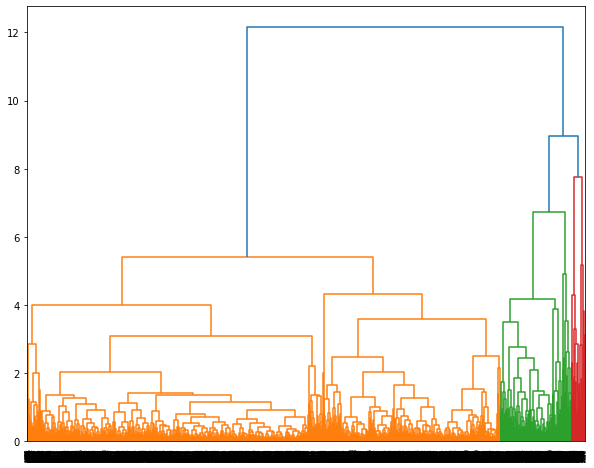

In [47]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:<br>**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
![](https://www.saedsayad.com/images/Clustering_average.png)

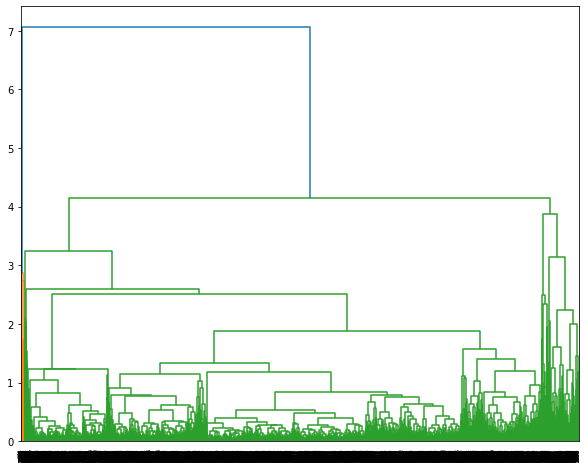

In [48]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Cutting the Dendrogram based on K

In [49]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

ag_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean')
ag_cluster.fit(rfm_df_scaled)

AgglomerativeClustering(n_clusters=3)

In [50]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

cluster_data= rfm.copy()
cluster_data['cluster_pred'] = ag_cluster.fit_predict(rfm_df_scaled)

In [51]:
ag_cluster.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [52]:
cluster_data

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels,cluster_pred
0,12346.0,0.00,2,325,2,0,2
1,12347.0,4310.00,182,1,1,0,1
2,12348.0,1797.24,31,74,0,0,0
3,12349.0,1757.55,73,18,0,0,0
4,12350.0,334.40,17,309,2,0,2
...,...,...,...,...,...,...,...
4366,18278.0,173.90,9,73,0,0,0
4367,18280.0,180.60,10,277,2,0,2
4368,18281.0,80.82,7,180,2,0,2
4369,18282.0,176.60,13,7,0,0,0


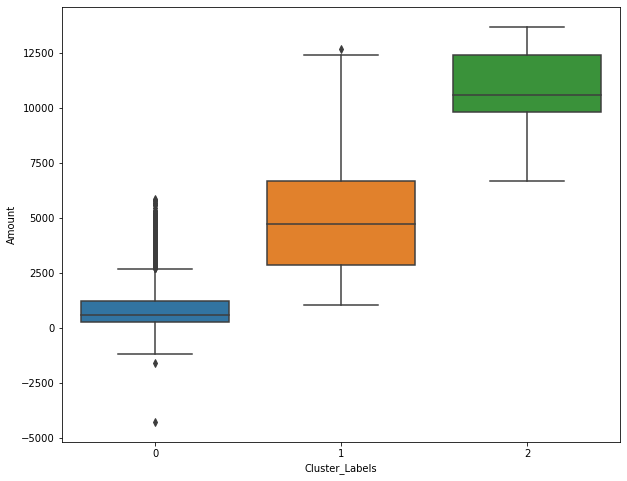

In [53]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

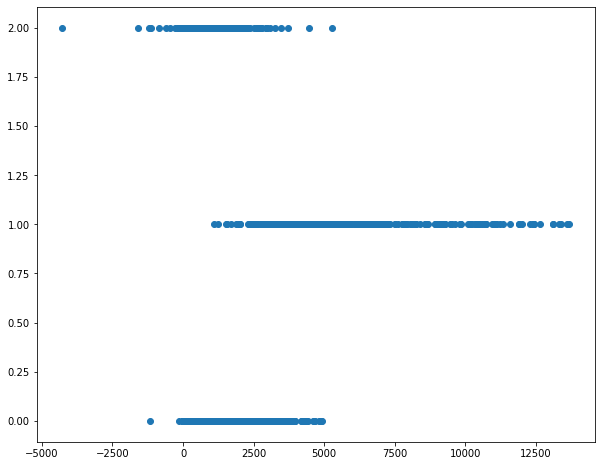

In [58]:
plt.scatter(cluster_data['Amount'], cluster_data['cluster_pred'], cmap='rainbow')

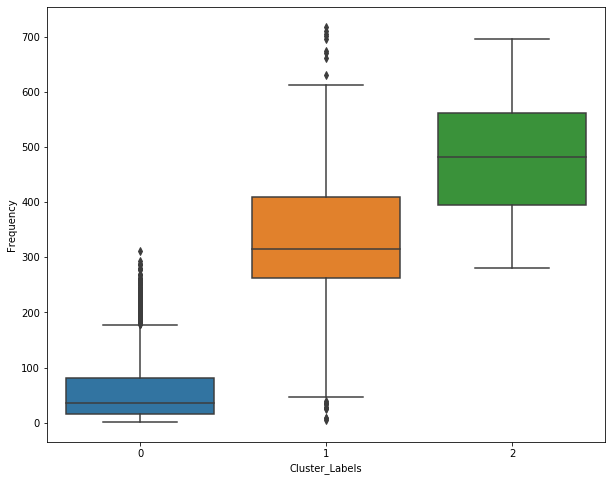

In [42]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

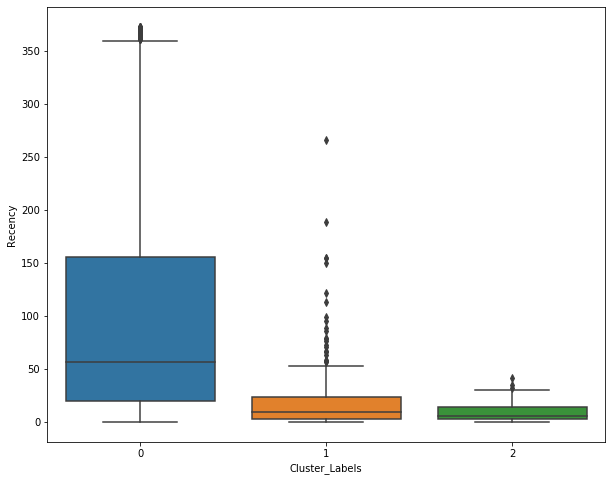

In [43]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

<a id="5"></a> <br>
## Step 5 : Final Analysis

### Inference:
K-Means Clustering with 3 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering with 3 Cluster Labels
- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster_Labels 2 are frequent buyers.
- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.